This notebook demonstartes the steps in Stability-based model selection for learning PDEs from data (PDE-STRIDE)
$$
u_t + uu_x = 0.1u_{xx}
$$
In this demo notebook, we show stability selection in combination with three different sparsity promoters LASSO, STRidge and IHT with debiasing 

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook
from Iterative_solvers_l0_l1 import *
import scipy.io as sio
import itertools
from operator import itemgetter, attrgetter
import matplotlib.pyplot as plt
from sklearn.linear_model import lars_path, enet_path, lasso_path
from itertools import cycle

import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression

import seaborn as sns
c = sns.color_palette("Blues",20)

Populating the interactive namespace from numpy and matplotlib


# Import data

In [2]:
X_APR    = loadtxt('Burgers/X_burgers.dat', dtype='double')
T_APR    = loadtxt('Burgers/T_burgers.dat', dtype='double') 
data = sio.loadmat('Burgers/burgers.mat')
u = real(data['usol'])
dx = X_APR[1] - X_APR[0]
dt = T_APR[1] - T_APR[0]
print(" shape of u ", u.shape)
print(" dt is ", dt, " dx is ", dx)

 shape of u  (256, 101)
 dt is  0.1  dx is  0.0625


# Create the design matrix

In [3]:
numpy.random.seed(0)
noise_level = 0.01
un = u + noise_level*std(u)*np.random.randn(u.shape[0],u.shape[1])

#y, X, description = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'FD', space_diff = 'FD')
# In this demo, we don't use SVD based denoising but simply use gaussian blur + polynomial differentiation
y, X, description = build_linear_system(un, dt, dx, D=4, P=3, time_diff = 'poly', space_diff = 'poly',deg_x = 5, deg_t = 5, 
                                      width_x = 10, width_t = 10)
print(" length of description ", len(description))
description_trunc, X_no_intercept = remove_intercept(X, description) # This step removes the constant column in the design
u_t = y

 The value of D is changed to 4  4
 length of description  20
i : 1 u
i : 2 u^2
i : 3 u^3
i : 4 u_{x}
i : 5 uu_{x}
i : 6 u^2u_{x}
i : 7 u^3u_{x}
i : 8 u_{xx}
i : 9 uu_{xx}
i : 10 u^2u_{xx}
i : 11 u^3u_{xx}
i : 12 u_{xxx}
i : 13 uu_{xxx}
i : 14 u^2u_{xxx}
i : 15 u^3u_{xxx}
i : 16 u_{xxxx}
i : 17 uu_{xxxx}
i : 18 u^2u_{xxxx}
i : 19 u^3u_{xxxx}
 shape of the truncated description  19
shape 19116 20
shape of no_intercept (19116, 19)


/lustre/projects/jupyterhub/maddukon/Data_driven/Stability_selection_results /PDE-STRIDE/Iterative_solvers_l0_l1.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  X_no_intercept[:,i-1] = X[:,i]


# Compute regularization path for a random sub-sample

In [4]:
np.random.seed(50)
reduced_size = 200
ordered = np.arange(0, len(u_t))
np.random.shuffle(ordered)

X_reduced = np.zeros((reduced_size, len(description_trunc))) # random sub-sample from the design matrix
y_reduced = np.zeros((reduced_size,1))                       # random sub-sample from the measurement vector
X_stand   = np.zeros((reduced_size, len(description_trunc))) # standardized sub-design matrix
y_stand   = np.zeros((reduced_size,1))                       # standardized sub-measurement vector

for i in range(0, reduced_size):
    X_reduced[i,:] = X_no_intercept[int(ordered[i]),:]
    y_reduced[i,:] = u_t[int(ordered[i])]

X_stand = preprocessing.scale(X_reduced)
y_stand = preprocessing.scale(y_reduced, with_std=False)
y_stand = y_stand.reshape(reduced_size,1)

mul_vector = np.matmul(X_stand.transpose(), y_stand)     
lambda_max = (1.0/reduced_size)*np.linalg.norm(mul_vector, np.inf)  # lambda_{max} in paper 
M             = 20 # M in the paper
factor        = np.exp(np.log(10.)/M)
lambda_regl   = np.zeros((M,1))
coeff_alpha   = np.zeros((len(description_trunc),M)) # stores the output

alphas_regl = np.zeros((M,1))
for alpha in range(0, M):
    alphas_regl[alpha] = lambda_max/factor**alpha
    
normalized_alphas_sample = np.zeros((M,))
normalized_alphas_sample = alphas_regl/alphas_regl[0]
neg_log_stable_lambda = -np.log10(normalized_alphas_sample)

print(" lambda max is ", alphas_regl[0], " lambda min is ", alphas_regl[M-1])
print(" lambda max is ", normalized_alphas_sample[0], " lambda min is ", normalized_alphas_sample[M-1])

p = X_stand.shape[1]
coefs_lasso   = np.zeros((p, M))
coefs_ihtd    = np.zeros((p, M))
coefs_STR     = np.zeros((p, M))

print(" norm is ", np.linalg.norm(X_stand.T.dot(X_stand),2))

for alpha in range(0, M):
    clf_l = linear_model.Lasso(alphas_regl[alpha], fit_intercept=False, max_iter=10000, tol=1e-8) #L1
    clf_l.fit(X_stand,y_stand)
    coefs_lasso[:,alpha] = clf_l.coef_
        
    clf_ihtd = Iterative_hard_thresholding_debias(X_stand, y_stand, alphas_regl[alpha], max_iter=10000, sub_iter=25, tol=1e-8, htp_flag = 1, print_flag=True)
    coefs_ihtd[:, alpha] = clf_ihtd[:]
    
    clf_STR = STRidge(X_stand, y_stand, alphas_regl[alpha], lam = 10**-5, max_iter=10000)
    coefs_STR[:,alpha] = clf_STR[:]

    print(" done with alpha ", alpha)

 lambda max is  [0.06333404]  lambda min is  [0.0071062]
 lambda max is  [1.]  lambda min is  [0.11220185]
 norm is  1805.231355509598
 done with alpha  0
 converged at iteration  4  frac_iter  0.0  flag  1
 done with alpha  1
 converged at iteration  4  frac_iter  0.0  flag  1
 done with alpha  2
 converged at iteration  4  frac_iter  0.0  flag  1
 done with alpha  3
 converged at iteration  5  frac_iter  0.0  flag  1
 done with alpha  4
 converged at iteration  5  frac_iter  0.0  flag  1
 done with alpha  5
 converged at iteration  12  frac_iter  0.07692307692307693  flag  1
 done with alpha  6
 converged at iteration  10  frac_iter  0.09090909090909091  flag  1
 done with alpha  7
 converged at iteration  11  frac_iter  0.08333333333333333  flag  1
 done with alpha  8
 converged at iteration  11  frac_iter  0.08333333333333333  flag  1
 done with alpha  9
 converged at iteration  11  frac_iter  0.08333333333333333  flag  1
 done with alpha  10
 converged at iteration  14  frac_iter 

/sw/apps/python3/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/lustre/projects/jupyterhub/maddukon/Data_driven/Stability_selection_results /PDE-STRIDE/Iterative_solvers_l0_l1.py:419: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if lam != 0: coeff[0,biginds] = np.linalg.lstsq(X[:, biginds].T.dot(X[:, biginds]) + lam*np.eye(len(biginds)),X[:, biginds].T.dot(y))[0].reshape(len(biginds),)


 converged at iteration  31  frac_iter  0.03125  flag  1
 done with alpha  18
 converged at iteration  32  frac_iter  0.030303030303030304  flag  1
 done with alpha  19


Text(0.5,0,' $ -log(\\lambda^{*}) $')

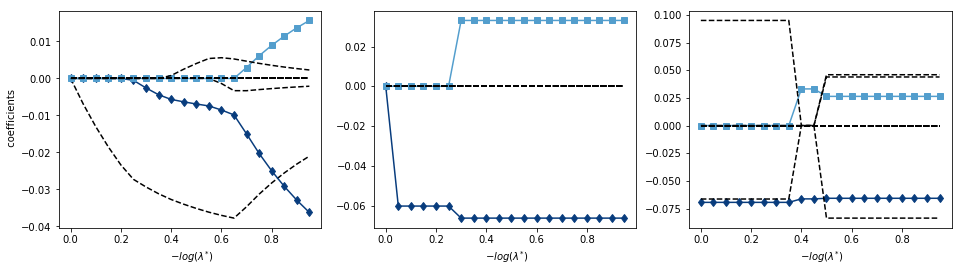

In [5]:
pylab.rcParams['figure.figsize'] = (16, 4.)
covar_1 = 4 # advection term
covar_2 = 7 # diffusion term

plt.subplot(1,3,1)
for i in range(0, p):
    if(i == covar_1):
        plt.plot(neg_log_stable_lambda, coefs_lasso[i,:],'-d',color=c[19])
    elif(i == covar_2):
        plt.plot(neg_log_stable_lambda, coefs_lasso[i,:],'-s',color=c[11])
    else:
        plt.plot(neg_log_stable_lambda, coefs_lasso[i,:],'--',color='black')
plt.xlabel(" $ -log(\lambda^{*}) $")
plt.ylabel("  coefficients ")
        
plt.subplot(1,3,2)
for i in range(0, p):
    if(i == covar_1):
        plt.plot(neg_log_stable_lambda, coefs_ihtd[i,:],'-d',color=c[19])
    elif(i == covar_2):
        plt.plot(neg_log_stable_lambda, coefs_ihtd[i,:],'-s',color=c[11])
    else:
        plt.plot(neg_log_stable_lambda, coefs_ihtd[i,:],'--',color='black')
plt.xlabel(" $ -log(\lambda^{*}) $")
        
plt.subplot(1,3,3)
for i in range(0, p):
    if(i == covar_1):
        plt.plot(neg_log_stable_lambda, coefs_STR[i,:],'-d',color=c[19])
    elif(i == covar_2):
        plt.plot(neg_log_stable_lambda, coefs_STR[i,:],'-s',color=c[11])
    else:
        plt.plot(neg_log_stable_lambda, coefs_STR[i,:],'--',color='black')
        
plt.rcParams.update({'font.size': 12})
plt.xlabel(" $ -log(\lambda^{*}) $")

In [6]:
B = 100; reduced_size = 1500; rescale = 1;
subsample_info_lasso, subsample_info_iht_d, \
            subsample_info_STR, alphas_sample = stability_selection(X_no_intercept, u_t, reduced_size, M, B, rescale)

/lustre/projects/jupyterhub/maddukon/Data_driven/Stability_selection_results /PDE-STRIDE/Iterative_solvers_l0_l1.py:453: ComplexWarning: Casting complex values to real discards the imaginary part
  y_reduced[i]   = y[int(ordered_reduced[i])]  # changed
/lustre/projects/jupyterhub/maddukon/Data_driven/Stability_selection_results /PDE-STRIDE/Iterative_solvers_l0_l1.py:419: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if lam != 0: coeff[0,biginds] = np.linalg.lstsq(X[:, biginds].T.dot(X[:, biginds]) + lam*np.eye(len(biginds)),X[:, biginds].T.dot(y))[0].reshape(len(biginds),)


 done with sample  0  size  1500
 done with sample  5  size  1500
 done with sample  10  size  1500
 done with sample  15  size  1500
 done with sample  20  size  1500
 done with sample  25  size  1500
 done with sample  30  size  1500
 done with sample  35  size  1500
 done with sample  40  size  1500
 done with sample  45  size  1500
 done with sample  50  size  1500
 done with sample  55  size  1500
 done with sample  60  size  1500
 done with sample  65  size  1500
 done with sample  70  size  1500
 done with sample  75  size  1500
 done with sample  80  size  1500
 done with sample  85  size  1500
 done with sample  90  size  1500
 done with sample  95  size  1500


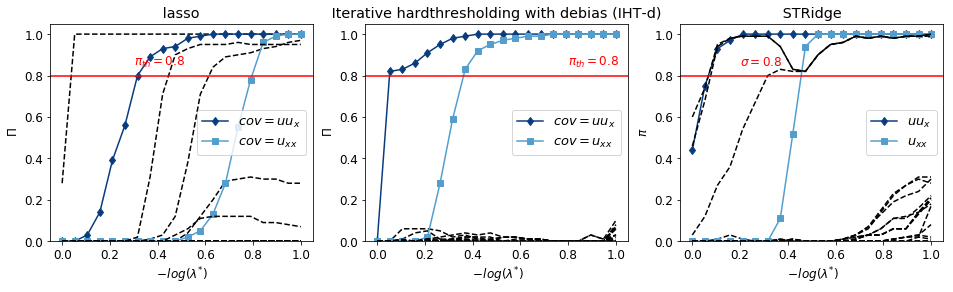

In [7]:
covar_1 =  4#PP + 1
covar_2 =  7#2*PP + 1

normalized_alphas_sample = np.zeros((B, M))
for sample in range(0, B):
    normalized_alphas_sample[sample,:] = alphas_sample[sample,:]/alphas_sample[sample,0]
neg_log_stable_lambda = -np.log10(normalized_alphas_sample[0,:])

importance_plot = np.zeros((p, M))
for alpha in range(0, M):
    for i in range(0, p):
        for sample in range(0, B):
            if(subsample_info_lasso[sample, i, alpha] != 0):
                importance_plot[i,alpha] = importance_plot[i,alpha] + 1

        importance_plot[i,alpha] = importance_plot[i,alpha]/B

plt.subplot(1,3,1)
for i in range(0, p):
    if(i == covar_1 ):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-d',color=c[19],label='$cov = %s$' %description_trunc[i])
    elif(i == covar_2):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-s', color=c[11],label='$cov = %s$' %description_trunc[i])
    else:
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '--', color='black')


plt.rcParams.update({'font.size': 12})
plt.title(" lasso ")
plt.xlabel(" $ -log(\lambda^{*}) $ ")
plt.ylabel(" $ \Pi $")
plt.ylim(0, 1.05)  
plt.legend(loc='best', prop={'size':13})
plt.text(0.3, 0.85,'$\pi_{th}=0.8$',color='red')
plt.axhline(y=0.8, color='r', linestyle='-')
pylab.rcParams['figure.figsize'] = (15, 7.5)

importance_plot = np.zeros((p, M))
for alpha in range(0, M):
    for i in range(0, p):
        for sample in range(0, B):
            if(subsample_info_iht_d[sample, i, alpha] != 0):
                importance_plot[i,alpha] = importance_plot[i,alpha] + 1

        importance_plot[i,alpha] = importance_plot[i,alpha]/B

plt.subplot(1,3,2)
for i in range(0, p):
    if(i == covar_1 ):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-d',color=c[19],label='$cov = %s$' %description_trunc[i])
    elif(i == covar_2):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-s', color=c[11],label='$cov = %s$' %description_trunc[i])
    else:
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '--', color='black')
        
plt.rcParams.update({'font.size': 12})
plt.title(" Iterative hardthresholding with debias (IHT-d) ")
plt.xlabel(" $ -log(\lambda^{*}) $ ")
plt.ylabel(" $ \Pi $")
plt.ylim(0, 1.05)  
plt.legend(loc='best', prop={'size':13})
plt.text(0.8, 0.85,'$\pi_{th}=0.8$',color='red')
plt.axhline(y=0.8, color='r', linestyle='-')
pylab.rcParams['figure.figsize'] = (15, 7.5)

importance_plot = np.zeros((p, M))
for alpha in range(0, M):
    for i in range(0, p):
        for sample in range(0, B):
            if(subsample_info_STR[sample, i, alpha] != 0):
                importance_plot[i,alpha] = importance_plot[i,alpha] + 1

        importance_plot[i,alpha] = importance_plot[i,alpha]/B

plt.subplot(1,3,3)
for i in range(0, p):
    if(i == covar_1 ):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-d',color=c[19],label='$%s$' %description_trunc[i])
    elif(i == covar_2):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-s', color=c[11],label='$%s$' %description_trunc[i])
    else:
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '--', color='black')
        

plt.rcParams.update({'font.size': 12})
plt.title(" STRidge ")
plt.xlabel(" $ -log(\lambda^{*}) $ ")
plt.ylabel(" $ \pi $")
plt.ylim(0, 1.05)  
plt.text(0.2, 0.85,'$ \sigma =0.8$', color='red')
plt.legend(loc='best', prop={'size':13})
plt.axhline(y=0.8, color='r', linestyle='-')
pylab.rcParams['figure.figsize'] = (17, 5)